In [1]:
import h5py
import yaml
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys; sys.path.insert(0, '..')
#sys.path.append('/dfs6/pub/nsankar1/pushes_bubbleML/BubbleML/sciml/models/ConvolutionalNeuralOperator')
from models.ConvolutionalNeuralOperator.CNOModule import CNO
from op_lib.disk_hdf5_dataset import DiskTempInputDataset
import os
import matplotlib.animation as animation

In [2]:
checkpoint_path = "./CNO_wall_super_heat_temp_upscale_input_dataset_1708085901.pt"
experiment_yaml_file = "/dfs6/pub/nsankar1/pushes_bubbleML/BubbleML/conf/experiment/experimental/cno/pb_temp_upscale.yaml"

with open(experiment_yaml_file, 'r') as file:
    model_params = yaml.safe_load(file)

model = CNO(in_dim = 27, 
            in_size = model_params['model']['in_size'], 
            N_layers = model_params['model']['n_layers'],
            out_dim = model_params['train']['future_window'],
            upscale_factor= model_params['model']['upscale_factor'])

checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
#print(checkpoint) #'train_data_max_temp' 'train_data_max_vel'
max_temp = checkpoint['train_data_max_temp']
max_vel = checkpoint['train_data_max_vel']

data_set_path = "/share/crsp/lab/amowli/share/BubbleML2/PoolBoiling-WallSuperheat-FC72-2D/Twall-90.hdf5"

DataSet = DiskTempInputDataset(data_set_path,
                 30,
                 transform=False,
                 time_window=model_params['train']['future_window'],
                 future_window=model_params['train']['time_window'],
                 push_forward_steps=1,
                 use_coords = True);

DataSet.normalize_temp_(max_temp)
DataSet.normalize_vel_(max_vel)

In [9]:
down_sample_factor = 4
segments = 6
offset = 30

inputs = []
labels = []
preds = []
input_temps = []
for i in range(segments):
    coords, temp, vel, label = DataSet.__getitem__(offset+(model_params['train']['future_window']*i))
    coords = torch.Tensor(coords.float()).unsqueeze(0) #to(int(os.environ['LOCAL_RANK']))
    temp = torch.Tensor(temp.float()).unsqueeze(0)
    vel = torch.Tensor(vel.float()).unsqueeze(0)
    label = torch.Tensor(label.float()).unsqueeze(0)
    input = torch.cat((coords[:,:,::down_sample_factor,::down_sample_factor], 
                       temp[:,:,::down_sample_factor,::down_sample_factor], 
                       vel[:,:,::down_sample_factor,::down_sample_factor]), dim=1)
    inputs += [input]
    factor = int((down_sample_factor/model_params['model']['upscale_factor']))
    labels += [label[:,:,::factor,::factor]]
    input_temps += [temp[:,:,::down_sample_factor,::down_sample_factor]]

labels = torch.cat(labels, dim = 1)
print(labels.shape, inputs[0].shape)
input_temps = torch.cat(input_temps, dim = 1)

for input in inputs:
    pred = model(input)
    preds += [pred]

preds = torch.cat(preds, dim = 1)
error = torch.abs(labels - preds)

print(preds.shape, labels.shape)

torch.Size([1, 30, 256, 256]) torch.Size([1, 27, 128, 128])
torch.Size([1, 30, 256, 256]) torch.Size([1, 30, 256, 256])


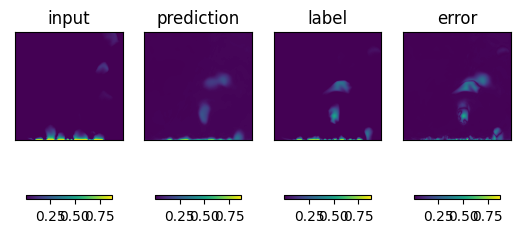

In [10]:
fig, ax = plt.subplots(1,4)

im = ax[0].imshow(np.flipud(input_temps.detach().numpy()[0,0]), animated = True)
im = ax[1].imshow(np.flipud(preds.detach().numpy()[0,0]), animated = True)
im = ax[2].imshow(np.flipud(labels.detach().numpy()[0,0]), animated = True)
im = ax[3].imshow(np.flipud(error.detach().numpy()[0,0]), animated = True)

ax[0].set_title("input")
ax[1].set_title("prediction")
ax[2].set_title("label")
ax[3].set_title("error")

for i in range(4):
    fig.colorbar(im, ax=ax[i], shrink=0.8, orientation='horizontal')
    ax[i].set_xticks([])
    ax[i].set_yticks([])


ims = []
for i in range(0, (model_params['train']['future_window']*segments) - 1):
    ims += [(ax[0].imshow(np.flipud(input_temps.detach().numpy()[0,i+1])), 
             ax[1].imshow(np.flipud(preds.detach().numpy()[0,i+1])),
             ax[2].imshow(np.flipud(labels.detach().numpy()[0,i+1])),
             ax[3].imshow(np.flipud(error.detach().numpy()[0,i+1])))]

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True,
                                repeat_delay=1000)

plt.show()

writergif = animation.PillowWriter(fps=5)
ani.save('pred.gif',writer=writergif)